<h1>Train & Evaluate & Test Optimal Model Using Label Encoding Without Value Recognition Across Columns</h1>

In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

<h3>A - Predicting using the tunned parameters of optimal model - RandomForestRegressor()</h3>

In [2]:
label_encoded_without_value_recognition_challenge_set_df = pd.read_csv('../data/label_encoded_without_value_recognition_challenge_set.csv')

# Pick up features from dataset
features = label_encoded_without_value_recognition_challenge_set_df[['adep', 'country_code_adep', 'ades', 'country_code_ades', 'aircraft_type', 
                                                                     'wtc', 'airline', 'flight_duration', 'taxiout_time', 'flown_distance', 
                                                                     'month-day', 'month', 'day_in_month']]

# Pick up target from dataset
target = label_encoded_without_value_recognition_challenge_set_df['tow']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123, shuffle=True)

model = RandomForestRegressor(
    bootstrap=True,
    ccp_alpha=0.001,
    criterion='squared_error',
    max_depth=30,
    max_features=None,
    min_samples_leaf=2,
    min_samples_split=8,
    n_estimators=100,
    random_state=123
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

<h3>B - Function to plot an example prediction with the tunned parameters</h3>

In [3]:
def plot_rmse(observed, predicted, show_error=False):
    # Calculate errors
    errors = observed - predicted
    squared_errors = errors**2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    # Plot the observed and predicted values
    plt.plot(observed, 'o', label='Observed Values')
    plt.plot(predicted, 'o', label='Predicted Values')
    
    # Plot the errors
    for i in range(len(observed)):
        plt.plot([i, i], [observed[i], predicted[i]], 'r--')
        if show_error:
            plt.text(i, (observed[i] + predicted[i]) / 2, f'{errors[i]:.1f}', ha='right', color='red')
    
    # Adding labels and title
    plt.xlabel('Data Points')
    plt.ylabel('Values')
    plt.title('Visualizing RMSE Calculation')
    plt.legend()
    plt.grid(True)
    
    # Show RMSE in the plot
    plt.text(1.5, max(observed) - 1, f'RMSE = {rmse:.3f}', fontsize=12, color='blue')

    plt.xticks([])
    plt.show()

<h3>C - Plotting random 100 points without showing individual datapoints errors</h3>

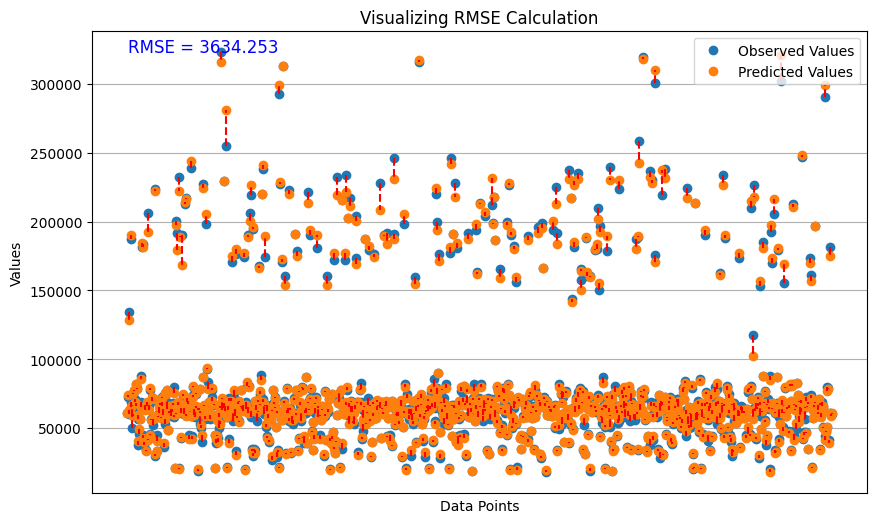

In [4]:
random_indices = np.random.choice(X_test.index, size=1000, replace=False)
X_test_sampled = X_test.loc[random_indices]
y_test_sampled = y_test.loc[random_indices]

y_pred_sampled = model.predict(X_test_sampled)

plot_rmse(observed=np.array(y_test_sampled), predicted=np.array(y_pred_sampled), show_error=False)

<h3>D - Plotting random 10 points and showing individual datapoints errors</h3>

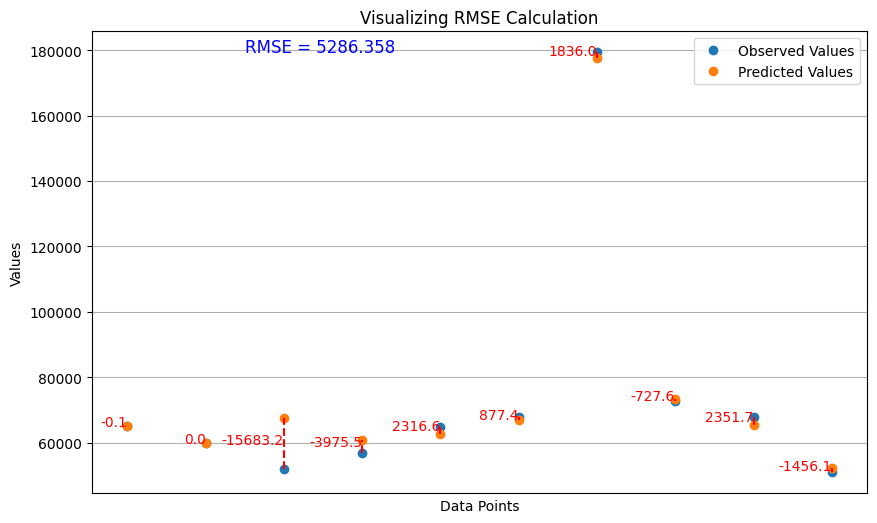

In [5]:
random_indices = np.random.choice(X_test.index, size=10, replace=False)

X_test_sampled = X_test.loc[random_indices]
y_test_sampled = y_test.loc[random_indices]

y_pred_sampled = model.predict(X_test_sampled)

plot_rmse(observed=np.array(y_test_sampled), predicted=np.array(y_pred_sampled), show_error=True)

In [38]:
def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

y_pred = model.predict(X_test)

print(f"RMSE: {rmse(y_test, y_pred)}")

RMSE: 3633.087674830854


In [39]:
def predict_within_limit(X_test):
    y_pred = model.predict(X_test)

    pred_df = pd.DataFrame({
        'aircraft_type': X_test['aircraft_type'],
        'y_pred': y_pred,
    })

    limited_y_pred = np.array([])
    overweight_predictions = []
    for index, row in pred_df.iterrows():
        aircraft_max_weight = label_encoded_without_value_recognition_challenge_set_df.loc[index]['aircraft_max_weight']
        if row['y_pred'] > aircraft_max_weight:
            over_limit = row['y_pred'] - aircraft_max_weight
            overweight_predictions.append(over_limit)
            limited_y_pred = np.append(limited_y_pred, [aircraft_max_weight])
        else:
            limited_y_pred = np.append(limited_y_pred, [row['y_pred']])
    
    print(f"Number of over limit predictions: {len(overweight_predictions)}")
    print(f"Sum of over limit predictions: {sum(overweight_predictions)}")
    print(f"Average of over limit predictions: {sum(overweight_predictions)/1052}")

    return limited_y_pred

limited_y_pred = predict_within_limit(X_test)

Number of over limit predictions: 1052
Sum of over limit predictions: 1954053.3308329755
Average of over limit predictions: 1857.4651433773531


In [40]:
print(f"RMSE: {rmse(y_test, limited_y_pred)}")

RMSE: 3626.2828842727704
